## Exploratory Data Analysis of Worldwide COVID-19 Cases From OurWorldInData

In [1]:
#Imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Use the requests library to perform a GET request from ourworldindata, and write the data to a csv file
filename = 'covid-data.csv'
data_url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
data_content = requests.get(data_url).content
csv_file = open(filename, 'wb')
csv_file.write(data_content)
csv_file.close()

In [3]:
#Create pandas dataframe from the csv file
df = pd.read_csv(filename)

In [4]:
#Check pandas dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56111 entries, 0 to 56110
Data columns (total 49 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   iso_code                            55794 non-null  object 
 1   continent                           55477 non-null  object 
 2   location                            56111 non-null  object 
 3   date                                56111 non-null  object 
 4   total_cases                         52472 non-null  float64
 5   new_cases                           55177 non-null  float64
 6   new_cases_smoothed                  54376 non-null  float64
 7   total_deaths                        43208 non-null  float64
 8   new_deaths                          55177 non-null  float64
 9   new_deaths_smoothed                 54376 non-null  float64
 10  total_cases_per_million             52191 non-null  float64
 11  new_cases_per_million               55113

In [5]:
#Calculate Total Cases by Location
total_cases = df.groupby('location')['new_cases'].sum()
total_cases = total_cases.sort_values(ascending=False)

#Establish 10 Worst Affected Countries
worst_countries = total_cases[1:11].index
cases = total_cases[1:11].values

#Calculate Total Deaths by Location
total_deaths = df.groupby('location')['new_deaths'].sum()
deaths = total_deaths[worst_countries].values 

In [6]:
#Create new dataframe with total cases and total deaths for the worst affected countries
worst_affected_df = pd.DataFrame({'Country': worst_countries, 'Total Cases': cases, 'Total Deaths': deaths})
worst_affected_df

,Country,Total Cases,Total Deaths
0,United States,10257826.0,239683.0
1,India,8636011.0,127571.0
2,Brazil,5664115.0,162397.0
3,France,1829659.0,42207.0
4,Russia,1817109.0,31161.0
5,Spain,1398613.0,39756.0
6,Argentina,1262462.0,34183.0
7,United Kingdom,1233775.0,49770.0
8,Colombia,1156675.0,33148.0
9,Italy,995463.0,42330.0


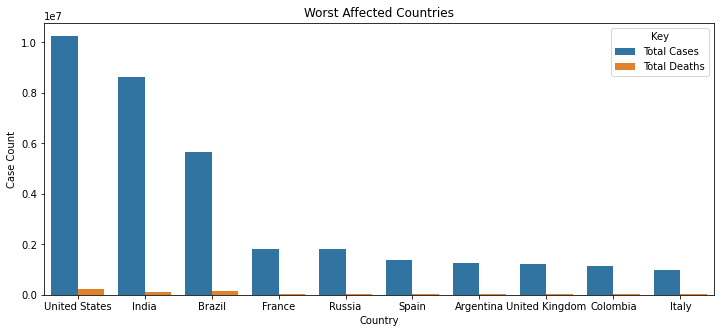

In [7]:
#Use pandas melt function to set Country as the identifier variable, and unpivot Total Cases & Deaths to the row axis
worst_data = pd.melt(worst_affected_df, id_vars = ['Country'],  value_vars=['Total Cases', 'Total Deaths'], 
                var_name='Key', value_name='Case Count')

#Plot the newly formatted dataframe as a barplot to visualize the total cases and deaths for each country
plt.figure(figsize=(12, 5))
sns.barplot(x="Country", hue="Key", y="Case Count", data=worst_data)
plt.title('Worst Affected Countries')
plt.show()

***It is evident that the United States is by far the worst affected country with almost 10 million total cases and close to 240,000 deaths. We can also see that while India has the second-highest number of cases, it has almost 35,000 less deaths than Brazil which currently has the third-highest amount of cases, and about 3 million less cases than India. France and Russia have almost the same amount of cases, but France has a moratality rate of about 2.3%, which is barely better than the US at 2.4%, and worse than Russia which currently has a mortality rate of approximately 1.7%. Spain, Argentina, the UK, Colombia, and Italy are relatively close in total amount of cases, but Italy and the UK both have mortality rates of over 4% wheres Spain, Argentina, and Columbia have roughly 2.8% mortality rates.***

In [8]:
#Calculate Total Tests by Location
total_tests = df.groupby('location')['new_tests'].sum().values
#Get the Population for each Location
population = df.groupby('location')['population'].nth(-1)

#Calculate the Test Rate for the Countries with the Best Test Rate
test_rate = (total_tests/population).sort_values(ascending = False)[:10]

In [9]:
#Check Data for Countries with the Best Test Rate
test_rate

location
Luxembourg              1.807814
United Arab Emirates    1.429438
Denmark                 0.961479
Bahrain                 0.873001
Iceland                 0.570690
Malta                   0.570156
Cyprus                  0.568570
Israel                  0.568201
United States           0.475193
Belgium                 0.455748
Name: population, dtype: float64

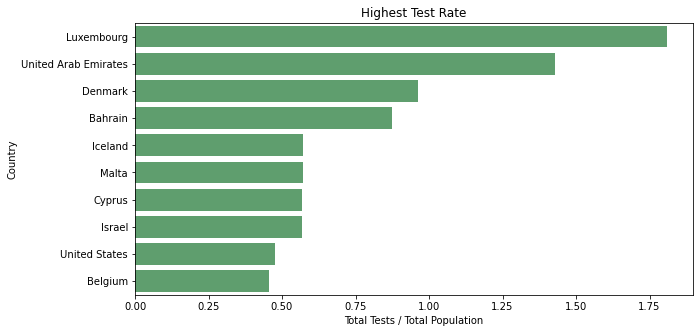

In [10]:
plt.figure(figsize=(10, 5))
sns.set_color_codes("deep")
sns.barplot(y = test_rate.index, x = test_rate.values, orient = "h", color="g")
plt.title('Highest Test Rate')
plt.xlabel('Total Tests / Total Population')
plt.ylabel('Country')
plt.show()

***Luxembourg and the UAE are doing exceptionally well having admininstered more tests than their entire populations! Denmark and Bahrain seem to have tested a great majority of their populations. Iceland, Malta, Cyprus, and Israel are also doing very well with over half their populations being tested while the US and Belgium are still shy of the 50% mark.***

In [11]:
#Create Separate Dataframes for the date & total_cases from the top 3 worst affected countries
country1 = 'United States'
country1_data = df.loc[df['location'] == country1]
country1_cases = country1_data[['date','total_cases']]

country2 = 'India'
country2_data = df.loc[df['location'] == country2]
country2_cases = country2_data[['date','total_cases']]

country3 = 'Brazil'
country3_data = df.loc[df['location'] == country3]
country3_cases = country3_data[['date','total_cases']]

#Merge all three datframes into a single dataframe using an ‘inner join’ operation on the date column
datewise_cases = (country1_cases.merge(country2_cases, how = 'inner', on = 'date')).merge(country3_cases, how = 'inner', on = 'date') 
print(datewise_cases.tail())

           date  total_cases_x  total_cases_y  total_cases
312  2020-11-07      9739545.0      8462080.0    5590025.0
313  2020-11-08      9860958.0      8507754.0    5590025.0
314  2020-11-09      9971651.0      8553657.0    5590025.0
315  2020-11-10     10110552.0      8591730.0    5653561.0
316  2020-11-11     10257826.0      8636011.0    5664115.0


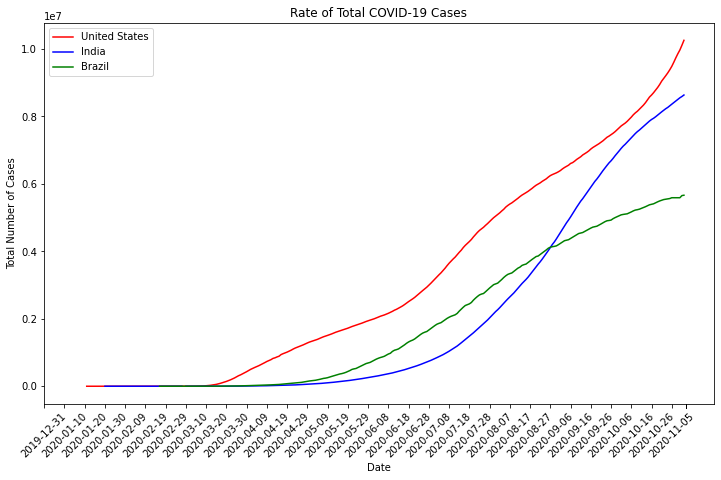

In [12]:
#Create a date series visualization with dates in increasing order on the X-axis, and number of cases on the Y-axis
plt.figure(figsize=(12, 7))
plt.plot(datewise_cases['date'].values, datewise_cases['total_cases_x'].values, color='red', label=country1)
plt.plot(datewise_cases['date'].values, datewise_cases['total_cases_y'].values, color='blue', label=country2)
plt.plot(datewise_cases['date'].values, datewise_cases['total_cases'].values, color='green', label=country3)
plt.xticks([datewise_cases['date'][i] if i%10 == 0 else '' for i in range(len(datewise_cases.index))], rotation = 45)
plt.xlabel('Date')
plt.ylabel('Total Number of Cases')
plt.title('Rate of Total COVID-19 Cases')
plt.legend()
plt.show()

***Looking at the US from March-June, overall cases were steadily increasing, but after June cases begin to rapidly increase. There are several factors that might have contributed to this such as mass disinformation about the lethality of the virus and a lack of national leadership regarding stringency measures such as mandatory lockdowns, social-distancing, and mask madates. The US is now reporting almost 150,000 new cases daily which should be cause for alarm, since I established earlier that the US has a mortality rate of roughly 2.4%. This means that over 3,500 people are receiving a potential death sentence each day in the US! Meanwhile, India's cases were rapidly increasing over the summer, but now daily cases have begun to decrease to under 45,000 which is nearly half of their September peak. Brazil has suffered the second dealiest outbreak next to the United States with over 160,000 total deaths to date, but since September daily cases have been steadily decreasing, and Brazil is now reporting just over 10,000 daily cases.***

In [13]:
#Create a dataframe for the worst countries to add features for correlation analysis
df_corr = pd.DataFrame(worst_countries.values, columns = ['Country'])
df_corr['Total Cases'] = cases

#Define Population Density for each country
pop_density = df.groupby('location')['population_density'].nth(-1)
df_corr['Population Density'] = pop_density[worst_countries].values

#Define Median Age for each country
median_age = df.groupby('location')['median_age'].nth(-1)
df_corr['Median Age'] = median_age[worst_countries].values

#Define Diabetes Prevalence for each country
diabetes_prevalence = df.groupby('location')['diabetes_prevalence'].nth(-1)
df_corr['Diabetes Prevelance'] = diabetes_prevalence[worst_countries].values

#Define Stringency Index for each country
stringency_index = df.groupby('location')['stringency_index'].mean()
df_corr['Stringency Index'] = stringency_index[worst_countries].values

#Define Cardiovascular Death Rate for each country
cvd_death_rate = df.groupby('location')['cardiovasc_death_rate'].nth(-1)
df_corr['Cardiovascular Death Rate'] = cvd_death_rate[worst_countries].values

#Define Proportion of Cases affecting those Aged 65 or Older
aged_65_older = df.groupby('location')['aged_65_older'].nth(-1)
df_corr['Aged 65 or Older'] = aged_65_older[worst_countries].values

#Define Proportion of Cases affecting those Aged 70 or Older
aged_70_older = df.groupby('location')['aged_70_older'].nth(-1)
df_corr['Aged 70 or Older'] = aged_70_older[worst_countries].values

#View dataframe to verify features
df_corr

,Country,Total Cases,Population Density,Median Age,Diabetes Prevelance,Stringency Index,Cardiovascular Death Rate,Aged 65 or Older,Aged 70 or Older
0,United States,10257826.0,35.608,38.3,10.79,53.478786,151.089,15.413,9.732
1,India,8636011.0,450.419,28.2,10.39,62.839841,282.280,5.989,3.414
2,Brazil,5664115.0,25.040,33.5,8.11,56.870255,177.961,8.552,5.060
3,France,1829659.0,122.578,42.0,4.77,51.332038,86.060,19.718,13.079
4,Russia,1817109.0,8.823,39.6,6.18,51.279586,431.297,14.178,9.393
5,Spain,1398613.0,93.105,45.5,7.17,53.140809,99.403,19.436,13.799
6,Argentina,1262462.0,16.177,31.9,5.50,86.213537,191.032,11.198,7.441
7,United Kingdom,1233775.0,272.898,40.8,4.28,54.550452,122.137,18.517,12.527
8,Colombia,1156675.0,44.223,32.2,7.44,78.611903,124.240,7.646,4.312
9,Italy,995463.0,205.859,47.9,4.78,54.754204,113.151,23.021,16.240


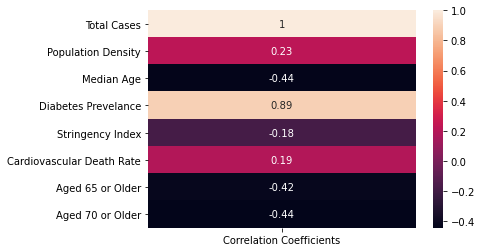

In [14]:
#Use pandas corr function to calculate the correlation of the features to the Total Cases and visualize with a heatmap
heatmap_df = pd.DataFrame({'Correlation Coefficients': df_corr.corr()['Total Cases'].values}, index = df_corr.corr()['Total Cases'].index)
sns.heatmap(heatmap_df, annot=True)
plt.show()

***Analyzing this heatmap, it is clear that Diabetes Prevalance (r=0.89) has a very strong uphill (positive) linear relationship with the number of Total Cases reported in each country. While Cardiovascular Deate Rate has a positive relationship (r=0.19), it's not enough confidently establish a meaningful correlation between Cardiovascular Death Rate and Total Cases. Another intersting observation is that Median Age (r=-0.44), Proportion of Cases Among Those 65 or Older (r=-0.42), and Proportion of Cases Among Those 70 or Older (r=-0.44) have moderate-weak downhill (negative) linear relationships with the number of Total Cases.***

***Notes for Further Data Analysis:***

***More feature selection for correlation of population metrics to Total Deaths or Mortality Rates***

***Analysis of Least Affected Countries***
